In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import pickle

In [10]:
class MalwareBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, num_layers=2, num_features=4, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc_sequence = nn.Linear(hidden_dim * 2, 64)
        self.fc_numeric = nn.Linear(num_features, 32)
        self.fc_combined = nn.Linear(64 + 32, 32)
        self.fc_output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, sequence, numeric):
        embedded = self.embedding(sequence)
        lstm_out, _ = self.lstm(embedded)
        sequence_features = torch.mean(lstm_out, dim=1)
        sequence_features = self.fc_sequence(sequence_features)
        
        numeric_features = self.fc_numeric(numeric)
        combined = torch.cat([sequence_features, numeric_features], dim=1)
        combined = self.dropout(combined)
        combined = torch.relu(self.fc_combined(combined))
        output = self.fc_output(combined)
        return output

In [11]:
class MalwareDataset(Dataset):
    def __init__(self, sequences, numeric_features, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.numeric_features = torch.tensor(numeric_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.numeric_features[idx], self.labels[idx]


In [12]:
class MalwareDetector:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.scaler = StandardScaler()
        self.process_vocab = {}
        self.path_vocab = {}
        
    def preprocess_data(self, df):
        """Preprocess sequences and numeric features"""
        def build_vocab(texts, min_freq=2):
            counter = Counter()
            for text in texts:
                if pd.notna(text):
                    counter.update(text.split(';'))
            vocab = {'<PAD>': 0, '<UNK>': 1}
            for word, freq in counter.items():
                if freq >= min_freq:
                    vocab[word] = len(vocab)
            return vocab
        
        self.process_vocab = build_vocab(df['exec_processes'])
        self.path_vocab = build_vocab(df['exec_paths'])
        
        def text_to_sequence(text, vocab, max_len=100):
            if pd.isna(text):
                return [0] * max_len
            tokens = text.split(';')[:max_len]
            sequence = [vocab.get(token, 1) for token in tokens]
            return sequence + [0] * (max_len - len(sequence))
        
        process_sequences = [text_to_sequence(text, self.process_vocab) for text in df['exec_processes']]
        path_sequences = [text_to_sequence(text, self.path_vocab) for text in df['exec_paths']]
        combined_sequences = [p + q for p, q in zip(process_sequences, path_sequences)]
        
        numeric_cols = ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets']
        numeric_features = self.scaler.fit_transform(df[numeric_cols])
        
        return combined_sequences, numeric_features
    
    def train(self, train_df, val_df, epochs=50, batch_size=32, lr=0.001):
        """Train the model"""
        train_sequences, train_numeric = self.preprocess_data(train_df)
        val_sequences, val_numeric = self.preprocess_data_inference(val_df)
        
        vocab_size = len(self.process_vocab) + len(self.path_vocab)
        self.model = MalwareBiLSTM(vocab_size).to(self.device)
        
        train_dataset = MalwareDataset(train_sequences, train_numeric, train_df['label'].values)
        val_dataset = MalwareDataset(val_sequences, val_numeric, val_df['label'].values)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            epoch_train_loss, train_correct, train_total = 0, 0, 0
            
            for sequences, numeric, labels in train_loader:
                sequences, numeric, labels = sequences.to(self.device), numeric.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(sequences, numeric).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                train_correct += (predicted == labels).sum().item()
                train_total += labels.size(0)
            
            # Validation
            self.model.eval()
            epoch_val_loss, val_correct, val_total = 0, 0, 0
            
            with torch.no_grad():
                for sequences, numeric, labels in val_loader:
                    sequences, numeric, labels = sequences.to(self.device), numeric.to(self.device), labels.to(self.device)
                    outputs = self.model(sequences, numeric).squeeze()
                    loss = criterion(outputs, labels)
                    
                    epoch_val_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)
            
            train_losses.append(epoch_train_loss / len(train_loader))
            val_losses.append(epoch_val_loss / len(val_loader))
            train_accs.append(train_correct / train_total)
            val_accs.append(val_correct / val_total)
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')
        
        self._plot_training_history(train_losses, val_losses, train_accs, val_accs)
        return self.model
    
    def preprocess_data_inference(self, df):
        """Preprocess data for inference using existing vocab"""
        def text_to_sequence(text, vocab, max_len=100):
            if pd.isna(text):
                return [0] * max_len
            tokens = text.split(';')[:max_len]
            sequence = [vocab.get(token, 1) for token in tokens]
            return sequence + [0] * (max_len - len(sequence))
        
        process_sequences = [text_to_sequence(text, self.process_vocab) for text in df['exec_processes']]
        path_sequences = [text_to_sequence(text, self.path_vocab) for text in df['exec_paths']]
        combined_sequences = [p + q for p, q in zip(process_sequences, path_sequences)]
        
        numeric_cols = ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets']
        numeric_features = self.scaler.transform(df[numeric_cols])
        
        return combined_sequences, numeric_features
    
    def predict(self, df):
        """Make predictions"""
        sequences, numeric_features = self.preprocess_data_inference(df)
        dataset = MalwareDataset(sequences, numeric_features, np.zeros(len(df)))
        loader = DataLoader(dataset, batch_size=32)
        
        self.model.eval()
        predictions = []
        
        with torch.no_grad():
            for sequences, numeric, _ in loader:
                sequences, numeric = sequences.to(self.device), numeric.to(self.device)
                outputs = self.model(sequences, numeric).squeeze()
                batch_predictions = torch.sigmoid(outputs).cpu().numpy()
                predictions.extend(batch_predictions)
        
        return np.array(predictions)
    
    def evaluate(self, df, threshold=0.5):
        """Evaluate model performance"""
        predictions = self.predict(df)
        binary_predictions = (predictions > threshold).astype(int)
        
        print(f"Classification Report (threshold={threshold}):")
        print(classification_report(df['label'], binary_predictions))
        print(f"AUC Score: {roc_auc_score(df['label'], predictions):.4f}")
        
        cm = confusion_matrix(df['label'], binary_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix (threshold={threshold})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return predictions, binary_predictions
    
    def find_optimal_threshold(self, df, thresholds=None):
        """Find optimal threshold based on F1-score"""
        if thresholds is None:
            thresholds = np.arange(0.1, 0.9, 0.05)
        
        predictions = self.predict(df)
        best_threshold = 0.5
        best_f1 = 0
        results = []
        
        for threshold in thresholds:
            binary_pred = (predictions > threshold).astype(int)
            report = classification_report(df['label'], binary_pred, output_dict=True)
            
            precision_1 = report['1']['precision']
            recall_1 = report['1']['recall']
            f1_1 = report['1']['f1-score']
            
            results.append({
                'threshold': threshold,
                'precision_malware': precision_1,
                'recall_malware': recall_1,
                'f1_malware': f1_1,
                'accuracy': report['accuracy']
            })
            
            if f1_1 > best_f1:
                best_f1 = f1_1
                best_threshold = threshold
        
        results_df = pd.DataFrame(results)
        
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.plot(results_df['threshold'], results_df['precision_malware'], 'b-', label='Precision')
        plt.plot(results_df['threshold'], results_df['recall_malware'], 'r-', label='Recall')
        plt.plot(results_df['threshold'], results_df['f1_malware'], 'g-', label='F1-Score')
        plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Malware Class Metrics vs Threshold')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 2, 2)
        plt.plot(results_df['threshold'], results_df['accuracy'], 'purple')
        plt.axvline(x=best_threshold, color='k', linestyle='--')
        plt.xlabel('Threshold')
        plt.ylabel('Overall Accuracy')
        plt.title('Overall Accuracy vs Threshold')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nOptimal threshold: {best_threshold:.3f}")
        print(f"Best F1-score (malware): {best_f1:.3f}")
        
        return best_threshold, results_df
    
    def _plot_training_history(self, train_losses, val_losses, train_accs, val_accs):
        """Plot training history"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

📊 Loading data...
✅ Data split - Train: 1485, Val: 495, Test: 496

🏋️ Training model...
Epoch 10/50: Train Loss: 0.4157, Val Loss: 0.4040, Train Acc: 0.8148, Val Acc: 0.8162
Epoch 20/50: Train Loss: 0.4069, Val Loss: 0.4032, Train Acc: 0.8290, Val Acc: 0.8162
Epoch 30/50: Train Loss: 0.3948, Val Loss: 0.4017, Train Acc: 0.8290, Val Acc: 0.8162
Epoch 40/50: Train Loss: 0.3964, Val Loss: 0.3996, Train Acc: 0.8269, Val Acc: 0.8162
Epoch 50/50: Train Loss: 0.3979, Val Loss: 0.4015, Train Acc: 0.8290, Val Acc: 0.8162


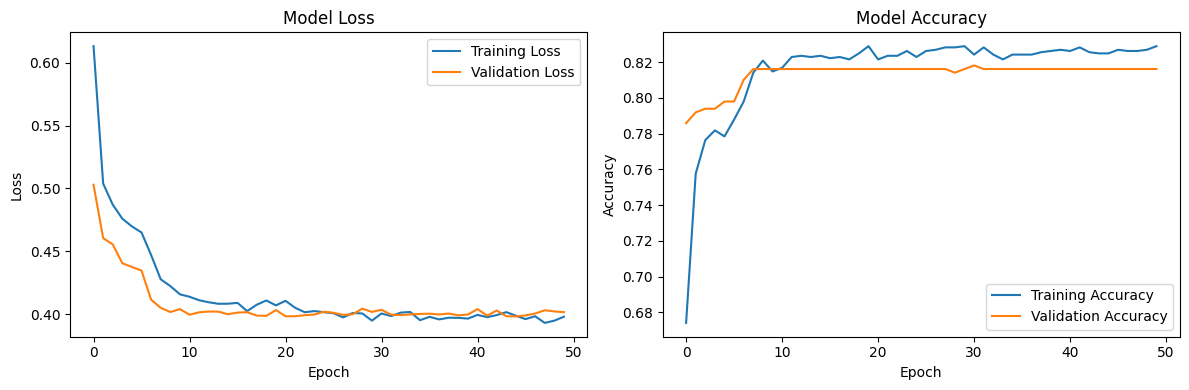


🎯 Finding optimal threshold...


c:\Users\kinan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kinan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kinan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

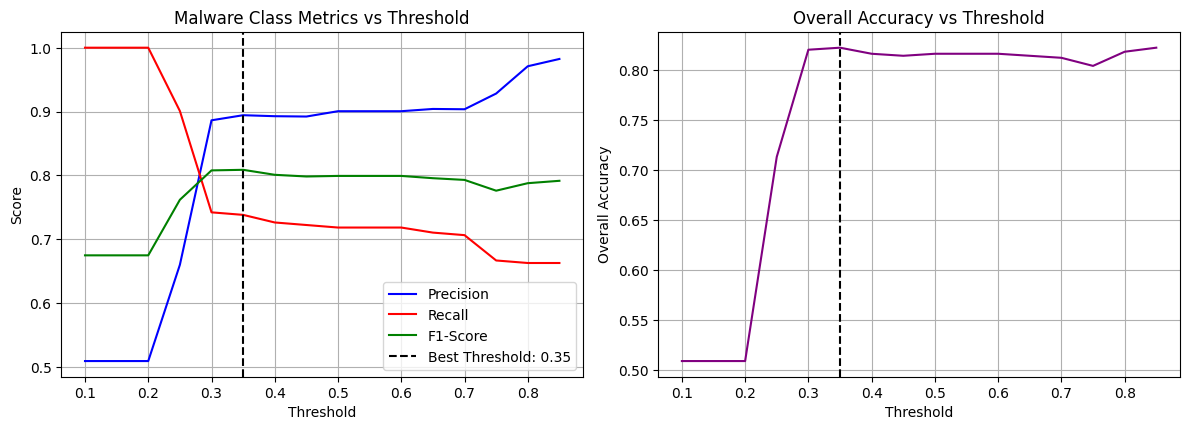


Optimal threshold: 0.350
Best F1-score (malware): 0.809

📊 Final evaluation (threshold=0.350):
Classification Report (threshold=0.3500000000000001):
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       244
           1       0.92      0.68      0.78       252

    accuracy                           0.81       496
   macro avg       0.83      0.81      0.81       496
weighted avg       0.83      0.81      0.81       496

AUC Score: 0.8418


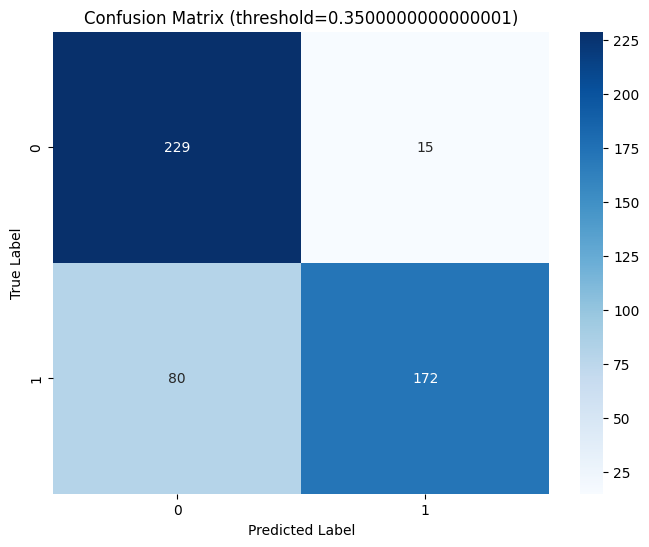


💾 Saving model...
✅ Model saved! Ready for production.


In [13]:
def main():
    """🚀 MAIN TRAINING PIPELINE"""
    # Load data
    print("📊 Loading data...")
    df = pd.read_csv('merged.csv')  # Your combined dataset
    
    # Split data
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    print(f"✅ Data split - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    # Initialize and train model
    print("\n🏋️ Training model...")
    detector = MalwareDetector()
    detector.train(train_df, val_df, epochs=50)
    
    # Find optimal threshold
    print("\n🎯 Finding optimal threshold...")
    optimal_threshold, _ = detector.find_optimal_threshold(val_df)
    
    # Evaluate on test set
    print(f"\n📊 Final evaluation (threshold={optimal_threshold:.3f}):")
    detector.evaluate(test_df, threshold=optimal_threshold)
    
    # Save model for production
    print("\n💾 Saving model...")
    torch.save(detector.model.state_dict(), 'malware_model.pth')
    
    with open('malware_scaler.pkl', 'wb') as f:
        pickle.dump(detector.scaler, f)
    
    vocab_data = {
        'process_vocab': detector.process_vocab,
        'path_vocab': detector.path_vocab
    }
    with open('malware_vocab.pkl', 'wb') as f:
        pickle.dump(vocab_data, f)
    
    config = {
        'optimal_threshold': optimal_threshold,
        'vocab_size': len(detector.process_vocab) + len(detector.path_vocab)
    }
    with open('malware_config.json', 'w') as f:
        json.dump(config, f)
    
    print("✅ Model saved! Ready for production.")
    return detector

if __name__ == "__main__":
    detector = main()